In [ ]:
import tensorflow as tf
import pandas as pd

In [ ]:
df = pd.read_csv("/Path_of_the_dataset.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
#Probar si tensorflow esta corriendo en una GPU
if tf.test.gpu_device_name():
  print(f'Se encontro el siguiente GPU: {tf.test.gpu_device_name()}')
else:
  print("Dewey esta no es tu familia")

Se encontro el siguiente GPU: /device:GPU:0


In [ ]:
mapper = {
    'tech':0,
    'business':1,
    'sport':2,
    'entertainment': 3,
    'politics':4
}
df['category'] = df['category'].map(mapper)
df.head()

,category,text
0,0,tv future in the hands of viewers with home th...
1,1,worldcom boss left books alone former worldc...
2,2,tigers wary of farrell gamble leicester say ...
3,2,yeading face newcastle in fa cup premiership s...
4,3,ocean s twelve raids box office ocean s twelve...


In [ ]:
!python -m spacy download en_core_web_lg

2023-10-19 22:19:57.478481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [ ]:
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words_en = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def vectorize(text):
    texto = text.lower()
    texto = re.sub(r'[^0-9A-Za-z \t]', '',texto)#Quita signos de puntuacion
    texto = word_tokenize(texto)
    texto = [palabra for palabra in texto if palabra not in stop_words_en]
    texto = [lemmatizer.lemmatize(palabra)for palabra in texto]
    texto = ' '.join(texto)
    texto = nlp(texto).vector
    return texto

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


<Axes: >

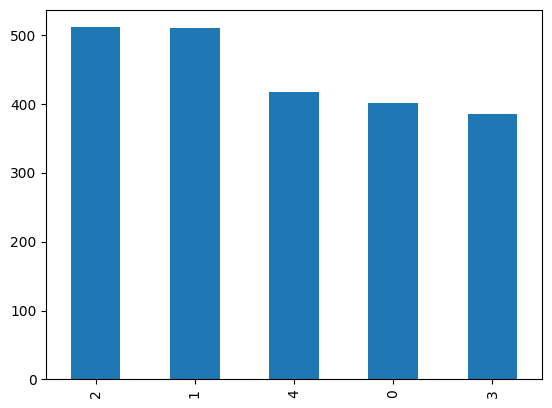

In [ ]:
df['category'].value_counts().plot(kind='bar')

In [ ]:
df['vector'] = df['text'].apply(vectorize)
df.head()

,category,text,vector
0,0,tv future in the hands of viewers with home th...,"[-0.35779276, 1.027878, -1.7133306, -0.3813384..."
1,1,worldcom boss left books alone former worldc...,"[-0.9598645, -0.3316427, -1.265666, 0.01640611..."
2,2,tigers wary of farrell gamble leicester say ...,"[-0.22371891, 1.2369883, -1.2397282, 0.1362095..."
3,2,yeading face newcastle in fa cup premiership s...,"[-2.2298324, -0.49553096, 0.6818949, -0.191311..."
4,3,ocean s twelve raids box office ocean s twelve...,"[-1.3094631, -0.6615322, -0.9717608, -0.574002..."


In [ ]:
from sklearn.model_selection import train_test_split

X = df['vector']
X= np.concatenate(X, axis = 0). reshape(-1,300)
y = df['category']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.75,random_state=101, stratify = y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten #Para una dimension por que es texto eL conv1D
from tensorflow.keras.optimizers import Adam #Para optimizar
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
early_stoping = EarlyStopping(monitor = 'val_loss',
                              patience = 5,
                              restore_best_weights = True)

In [ ]:
y_train

20      0
1678    2
1450    4
1194    1
499     1
       ..
1806    4
2070    1
1623    0
4       3
1432    1
Name: category, Length: 1668, dtype: int64

In [ ]:
y_train = to_categorical(y_train,5)
y_test = to_categorical(y_test,5)

In [ ]:
y_train

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
#Tenemos que acomodar en 3 dimensiones para que tensorflow jale

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [ ]:
model = Sequential()
model.add(Conv1D(32,2,activation = "relu", input_shape = X_train[0].shape))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.35))
model.add(Dense(5, activation = 'softmax'))

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs = 100,
                    validation_data=(X_test, y_test),
                    callbacks = [early_stoping])

Epoch 1/100
53/53 [==============================] - 10s 10ms/step - loss: 1.3870 - accuracy: 0.4646 - val_loss: 1.0517 - val_accuracy: 0.8689
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.8842 - accuracy: 0.7608 - val_loss: 0.5693 - val_accuracy: 0.9102
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5994 - accuracy: 0.8201 - val_loss: 0.3710 - val_accuracy: 0.9013
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 0.4721 - accuracy: 0.8561 - val_loss: 0.2862 - val_accuracy: 0.9138
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 0.4132 - accuracy: 0.8693 - val_loss: 0.2409 - val_accuracy: 0.9264
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 0.3418 - accuracy: 0.8909 - val_loss: 0.2201 - val_accuracy: 0.9390
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 0.3120 - accuracy: 0.9017 - val_loss: 0.1978 - val_accuracy: 0.9336
Epoch 8/100

In [ ]:
metrics = pd.DataFrame(history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,1.386979,0.464628,1.051738,0.868941
1,0.884186,0.760791,0.569318,0.910233
2,0.599398,0.820144,0.371016,0.901257
3,0.472102,0.856115,0.286217,0.913824
4,0.413178,0.869305,0.240885,0.926391


<Axes: >

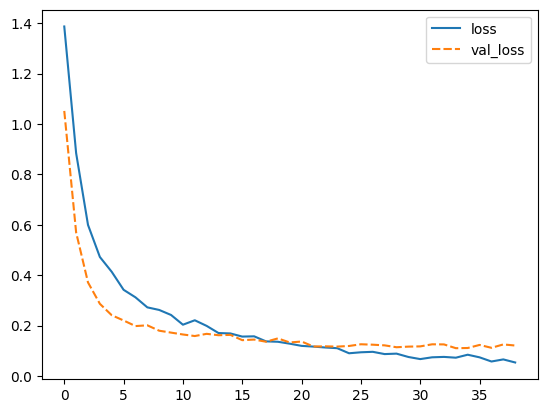

In [ ]:
import seaborn as sns
sns.lineplot(data = metrics[['loss', 'val_loss']])

<Axes: >

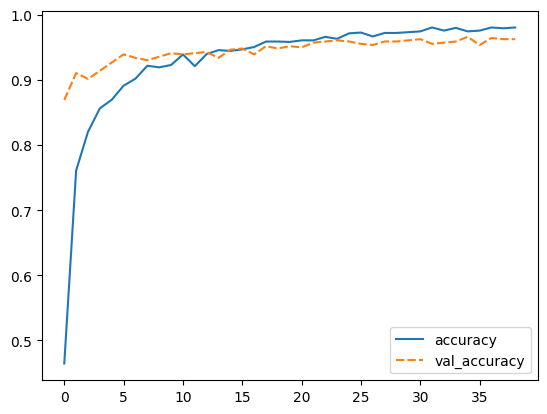

In [ ]:
sns.lineplot(data = metrics[['accuracy', 'val_accuracy']])

In [ ]:
y_pred = model.predict(X_test)

18/18 [==============================] - 0s 5ms/step


In [ ]:
y_pred = np.argmax(model.predict(X_test), axis = -1) #Se hace eso para que sean clasificaciones y no etiquetas

18/18 [==============================] - 0s 2ms/step


In [ ]:
y_test = np.argmax(y_test, axis = -1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       100
           1       0.93      0.96      0.95       128
           2       0.98      1.00      0.99       128
           3       1.00      0.94      0.97        97
           4       0.93      0.91      0.92       104

    accuracy                           0.96       557
   macro avg       0.96      0.96      0.96       557
weighted avg       0.96      0.96      0.96       557



<Axes: >

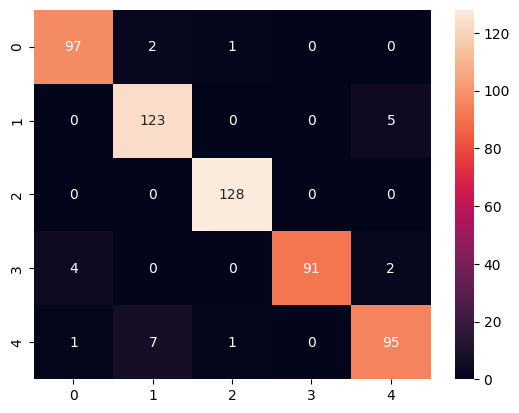

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = '.0f')

In [ ]:
#Poner etiquetas al clasification report
target_names = ['tech', 'business', 'sport', 'entertainment', 'politics']
print(classification_report(y_test,y_pred,target_names = target_names))

               precision    recall  f1-score   support

         tech       0.95      0.97      0.96       100
     business       0.93      0.96      0.95       128
        sport       0.98      1.00      0.99       128
entertainment       1.00      0.94      0.97        97
     politics       0.93      0.91      0.92       104

     accuracy                           0.96       557
    macro avg       0.96      0.96      0.96       557
 weighted avg       0.96      0.96      0.96       557



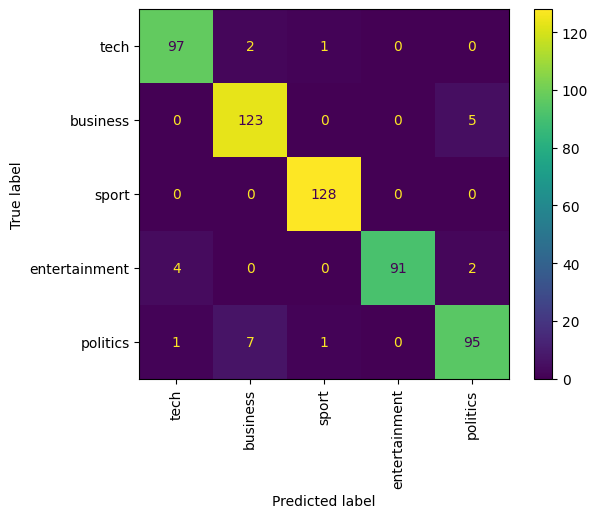

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_pred,
                                        display_labels = target_names,
                                        cmap = 'viridis',
                                        xticks_rotation='vertical')

In [ ]:
def predecir(texto):
  texto = vectorize(texto)
  texto = texto.reshape(1,-1)
  texto = scaler.transform(texto)
  texto = texto.reshape(1,300,1)
  texto = model.predict(texto)
  print(f'''
  CATEGORY              PROBABILITY
  ======================================
  Tech:                 {texto[0][0]}
  Business:             {texto[0][1]}
  Sport:                {texto[0][2]}
  Entertainment:        {texto[0][3]}
  Politics:             {texto[0][4]}
  ''')

In [ ]:
text = '''
As temperatures fall and a second winter of war approaches, Ukraine fears that the international enthusiasm for its cause that followed Russia’s invasion is cooling too. Slovakia halted military aid after pro-Russian Robert Fico’s party took power. Poland, one of Ukraine’s staunchest allies, had already suspended weapons transfers following a dispute over Kyiv’s grain exports – though things may well improve after the opposition unexpectedly claimed victory in last week’s elections. Now US attention is consumed by the Middle East, and Russia will be keen to keep it there.
Volodymyr Zelenskiy was quick to voice his support for Israel last week following the atrocities by Hamas. But the Ukrainian president also warned that “there is only a certain amount of military support to share”. There may be direct competition for some weaponry. Mr Zelenskiy also acknowledged that next year’s US presidential election brings uncertainty. Last month, aid for Ukraine was stripped from a government funding package to ensure its passage through Congress. Hardline Republicans are increasingly vociferous in their opposition to supplying further aid, and are gaining traction, not least due to the battle to become House speaker. Some are exploiting the Israel-Hamas war to cynically argue that the US can’t afford to back Ukraine too, although Kyiv’s supporters hope it may be possible to push through a joint Israel-Ukraine package. While US deliveries will continue for now, Kyiv could start rationing its use of arms if it cannot count on timely resupplies.

Earlier this month, European leaders, including Emmanuel Macron, assured Ukraine that their support would not flag. But as Josep Borrell, the EU foreign affairs chief, pointed out, Europe cannot fill a US gap. In part, this is a question of logistics as well as willpower, with arms inventories still running low.

Ukraine’s first use of US-supplied long-range ATACMS missiles to strike airbases in Russian-held areas on Tuesday may have offered a small fillip to morale. But its counteroffensive has failed to make significant progress, Moscow is finding fresh sources of manpower, and the White House says that North Korea has now shipped weapons to Russia. Xi Jinping and Vladimir Putin’s meeting in Beijing on Wednesday, at the belt and road initiative forum, also underscored that China is maintaining its staunch economic and diplomatic support. Russia believes that simply grinding on will not only sap Ukrainian morale, supplies and troops, but will also improve its odds as the mood in the US shifts.

The danger is not only that Russia holds and retakes territory. It is also that it will probably launch a renewed attack on Ukraine’s power grid to freeze the country into submission. Despite the extraordinary efforts of engineers, the system has not fully regained its prewar capacity.
'''

In [ ]:
predecir(text)

1/1 [==============================] - 0s 28ms/step

  CATEGORY              PROBABILITY
  Tech:                 0.0057180798612535
  Business:             0.6407758593559265
  Sport:                0.007240221370011568
  Entertainment:        8.309412805829197e-06
  Politics:             0.3462575376033783
  
